In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
os.getcwd()

'/Users/btseytlin/Documents/toloka_sociology/notebooks'

In [8]:
df = pd.read_csv('../data/final/final.csv')
df.shape

(4464, 71)

In [9]:
df=df[(df['source'] == 'world_values_survey')|(df['failed_control'] == False)]
df.shape

(3767, 71)

In [11]:
df.head().T

,0,2,7,9,10
ID,1090643861.0,1090636590.0,1090632694.0,1090631809.0,1090631142.0
Время создания,2022-02-09 21:37:05,2022-02-09 21:29:54,2022-02-09 21:25:52,2022-02-09 21:25:00,2022-02-09 21:24:18
Время изменения,2022-02-09 21:37:05,2022-02-09 21:29:54,2022-02-09 21:25:52,2022-02-09 21:25:00,2022-02-09 21:24:18
Ваш пол,Женский,Женский,Женский,Женский,Женский
Сколько вам лет?,более 50,более 50,более 50,более 50,более 50
...,...,...,...,...,...
Q262: Age,NaN,NaN,NaN,NaN,NaN
source_age,50+,50+,50+,50+,30-49
source_sex,female,female,female,female,female
self_reported_age,50+,50+,50+,50+,50+


In [12]:
from scipy.stats import ttest_ind

def plot_cats_by_category_normalized(df, col, category='source_age'):
    if category=='source_age':
        cat_values = ['29', '30-49', '50+']
    elif category =='source_sex':
        cat_values = ['male', 'female']
    else:
        cat_values = df[category].unique()
    fig, axs = plt.subplots(1, len(cat_values), figsize=(15, 10), sharey='all')
    for i, category_elem in enumerate(cat_values):
        category_df = df[df[category]==category_elem]
        width = 0.25
        vcounts = category_df[col].value_counts(normalize=True).sort_index()
        ticks = vcounts.index
        r = np.arange(len(ticks))
        for j, source in enumerate(['ours', 'world_values_survey']):
            source_df = category_df[category_df.source==source]
            vcounts = source_df[col].value_counts(normalize=True)
            vals = [(vcounts[t] if t in vcounts.index else 0) for t in ticks]
            axs[i].bar(r + width*j, vals, width=width, label=source)
            axs[i].set_xticks(r + width/2, ticks)
        axs[i].set_title(f'{category} = {category_elem}')
        axs[i].set(xlabel=None)

    axs[0].set(ylabel="Fraction")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.suptitle(col)
    plt.show()


def plot_cats(df, col):
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, hue='source', data=df)
    plt.title(col)
    plt.show()



def ttest(df, col):
    data1 = list(df[df.source=='ours'][col])
    data2 = list(df[df.source!='ours'][col])

    stat, p = ttest_ind(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
        


In [13]:
from scipy.stats import chi2_contingency

def make_pivot_df(df, col):
    df_copy = df.copy()
    df_copy['ID'] = list(range(len(df_copy)))
    df_copy = df_copy.set_index(['ID', 'source'])
    df_copy['person_ID'] = list(range(len(df_copy)))

    df_pivot = pd.pivot_table(df_copy, 
                              index='source',
                              values='person_ID',
                              columns=col,
                              aggfunc=pd.Series.nunique)
    return df_pivot

def chi2test(df, col, print_stuff=True):
    pivot = make_pivot_df(df, col).fillna(0)
    stat, p, dof, ex = chi2_contingency(pivot, correction=False)
    if print_stuff:
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p < 0.05:
            print('Probably different distributions')
        else:
            print('Probably the same distribution')
    return p

In [14]:
_, p, _, _ = chi2_contingency([[100, 100], [100, 100]])
p

1.0

In [15]:
_, p, _, _ = chi2_contingency([[0, 100], [100, 0]])
p

1.5431200214053197e-44

In [16]:
# for col in df.columns:
#     p = chi2test(df, col, print_stuff=False)
#     if p > 0.05:
#         print("No diff in column", col)
#     #print(p, col)

## Наркозависимый - идентично

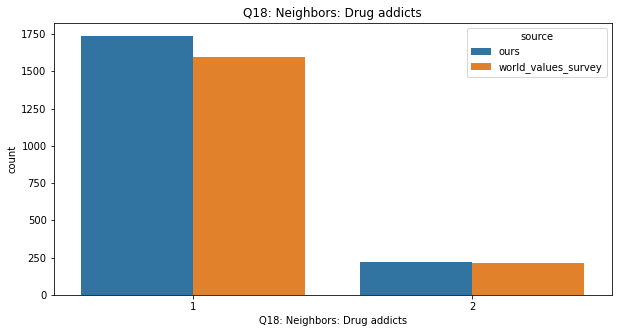

In [17]:
plot_cats(df, "Q18: Neighbors: Drug addicts")

In [18]:
chi2test(df, 'Q18: Neighbors: Drug addicts')

stat=0.312, p=0.577
Probably the same distribution


0.576500840829252

## В интернете люди меньшие расисты 

* среди всех возрастных групп
* одинаково среди женщин и мужчин

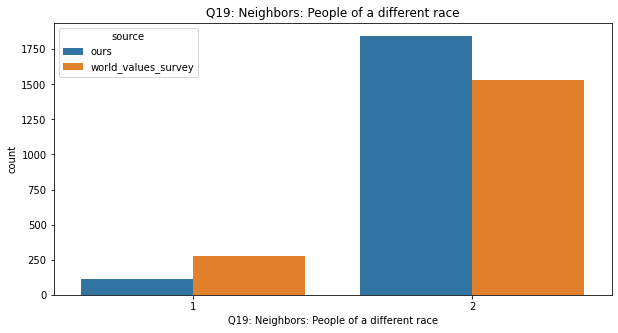

stat=95.810, p=0.000
Probably different distributions


1.264870451504954e-22

In [19]:
col = 'Q19: Neighbors: People of a different race'
plot_cats(df, col)
chi2test(df, col)

## В интернете люди меньшие гомофобы
* среди всех возрастов
* одинаково среди женщин и мужчин
* в интернете женщины чуть более толерантны к гомосексуализму, чем они толерантнее в WWS

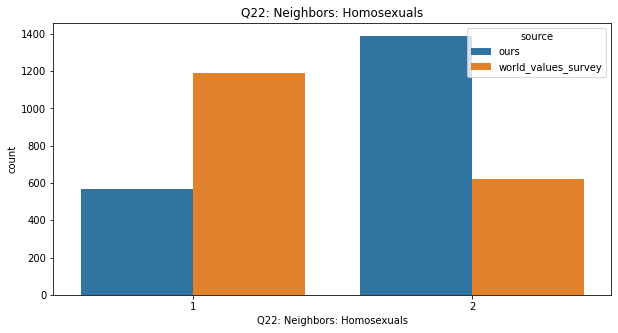

stat=505.028, p=0.000
Probably different distributions


7.656147047197572e-112

In [20]:
col = 'Q22: Neighbors: Homosexuals'
plot_cats(df, col)
chi2test(df, col)

## Толератнее к иммигрантам
* среди всех возрастов
* одинаково среди женщин и мужчин
* женщины в интернете чуть толерантнее

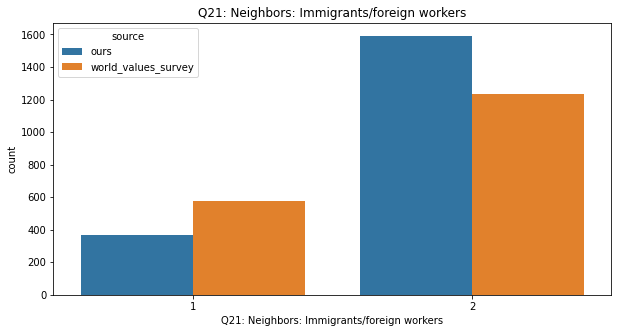

stat=86.992, p=0.000
Probably different distributions


1.0896002025012306e-20

In [21]:
col = 'Q21: Neighbors: Immigrants/foreign workers'
plot_cats(df, col)
chi2test(df, col)

## Толератнее к мусульманам

* среди всех возрастных групп, кроме молодёжи т.е. существует preference falsification среди страших возрастов ИЛИ интернет плодит исламофобию
* женщины в интернете СТАТИСТИЧЕСКИ толерантнее к иноверцам

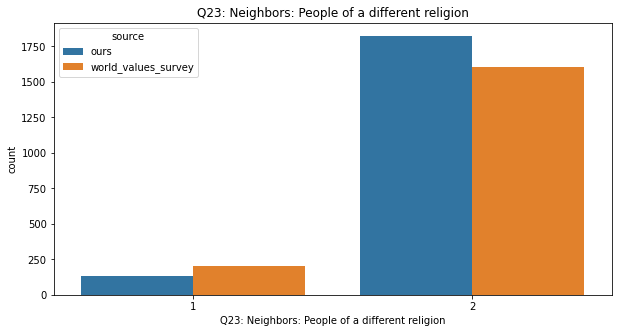

stat=23.113, p=0.000
Probably different distributions


1.527821111734278e-06

In [22]:
col = 'Q23: Neighbors: People of a different religion'
plot_cats(df, col)
chi2test(df, col)

## В интернете меньше сексизма (preference falsification)

* среди пожилых людей сексизма чуть больше в интернете (см. п. 4)
* среди молодёжи разница НЕ значима
* одинаково среди женщин и мужчин

Мужчины лучше женщин в политике

1 - полностью согласен

2 - скорее согласен

3 - скорее не согласен

4 - полностью не согласен

-1 - затрудняюсь


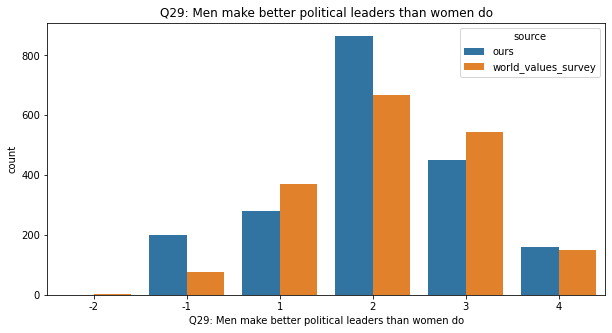

stat=100.090, p=0.000
Probably different distributions


5.0604787642910114e-20

In [23]:
col = 'Q29: Men make better political leaders than women do'
plot_cats(df, col)
chi2test(df, col)

## Столько же гомофобии
* меньше гомофобии только у МОЛОДЁЖИ - preference falsification
* женщины МЕНЕЕ ГОМОФОБНЫ в интернете

Гомосексуальные пары такие же хорошие родители

1 - полностью согласен

2 - скорее согласен

3 - ни согласен, ни несогласен

4 - скорее не согласен

5 - полностью не согласен

-1 - затрудняюсь ответить

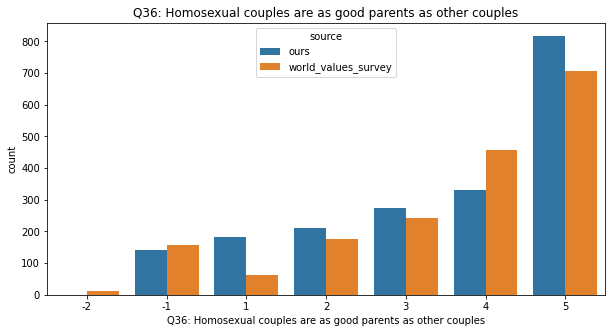

stat=-1.214, p=0.225
Probably the same distribution
stat=100.766, p=0.000
Probably different distributions


1.7363938815179288e-19

In [24]:
col = 'Q36: Homosexual couples are as good parents as other couples'
plot_cats(df, col)
ttest(df, col)
chi2test(df, col)

**Статистически женщины в интернете менее гомофобны**

## В Интернете чуть больше склонны к протестам

* среди всех возратсных групп
* одинаково среди женщин и мужчин

Посетили бы вы несанкицонированный митинг

1 - уже посещал

2 - мог бы посетить

3 - никогда бы не посетил

-1 - затрудняюсь ответить

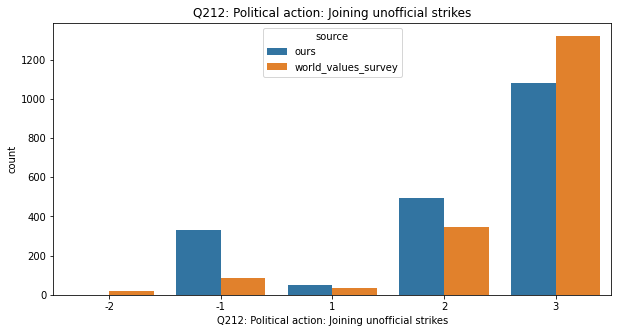

stat=-12.078, p=0.000
Probably different distributions
stat=211.569, p=0.000
Probably different distributions


1.2215568406397278e-44

In [25]:
col = 'Q212: Political action: Joining unofficial strikes'
plot_cats(df, col)
ttest(df, col)
chi2test(df, col)

## В Интернете также не доверяют правительству

* разница статистичеси не значима по всем возрастным группам
* среди женщин и мужчин разница также статистически НЕ значима

Доверяете ли вы правительству

1 - полностью доверяю

2 - скорее доверяю

3 - скорее не доверяю

4 - полностью не доверяю

-1 - затрудняюсь ответить

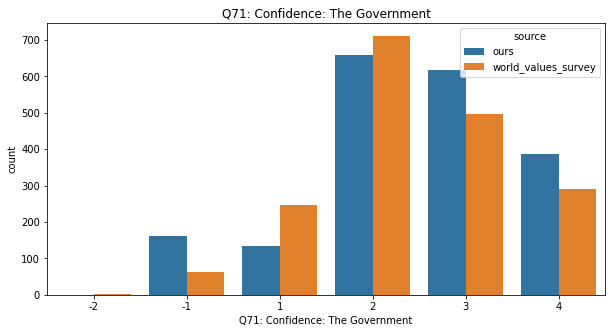

stat=1.058, p=0.290
Probably the same distribution
stat=102.184, p=0.000
Probably different distributions


1.8304941985017775e-20

In [26]:
col = 'Q71: Confidence: The Government'
plot_cats(df, col)
ttest(df, col)
chi2test(df, col)

## В Интернете на таком же уровне не доверяют полиции

* среди всех возрастных групп
* среди женщин и мужчин


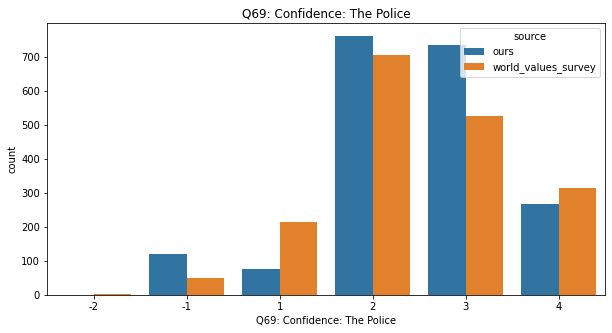

stat=132.753, p=0.000
Probably different distributions


6.198345635992266e-27

In [27]:
col = 'Q69: Confidence: The Police'
plot_cats(df, col)
chi2test(df, col)

## PREFERENCE FALSIFICATION (!!!) - БОЛЬШЕ СЕКСИЗМА

* среди всех возрастных групп, кроме молодёжи (молодёжь не демонстрирует БОЛЬШЕ сексизма)
* среди женщин и мужчин НЕ понятно
    * вроде как ЖЕНЩИНЫ больше ДОВЕРЯЮТ
    * мужчины больше НЕ ДОВЕРЯЮТ

1 - полностью доверяю

2 - скорее доверяю

3 - скорее не доверяю

4 - полностью не доверяю

-1 - затрудняюсь ответить

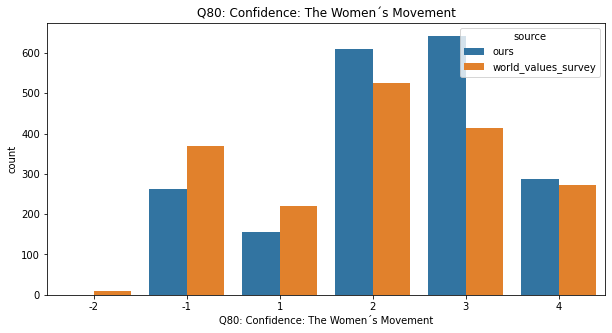

stat=89.858, p=0.000
Probably different distributions


7.196823979218531e-18

In [28]:
col = 'Q80: Confidence: The Women´s Movement'
plot_cats(df, col)
chi2test(df, col)

## В Интернете больше верят в фальсификации 

* среди всех возрастных групп
* среди женщин и мужчин

Как часто в стране фальсифицируют выборы?

1 - очень часто

2 - скорее часто

3 - не очень часто

4 - совсем не часто

-1 - затрудняюсь ответить

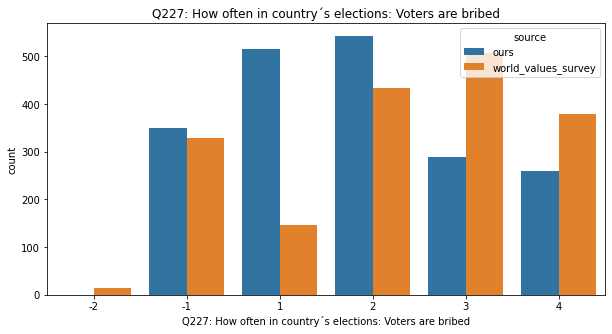

stat=308.934, p=0.000
Probably different distributions


1.2014599698572e-64

In [29]:
col = 'Q227: How often in country´s elections: Voters are bribed'
plot_cats(df, col)
chi2test(df, col)

## Поляризация относительно иностранцев, люди больше за квоты И больще за пускать всех подряд
* среди всех возрастных групп
* среди женщин и мужчин

Имиграционная политика

1 - пускать любого, кто захочет

2 - пускать пока есть работа

3 - квоты

4 - никого не пускать

-1 - затрудняюсь

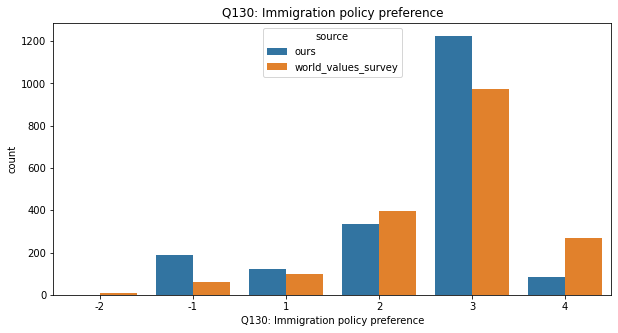

stat=197.084, p=0.000
Probably different distributions


1.1945970844613273e-40

In [30]:

col = 'Q130: Immigration policy preference'
plot_cats(df, col)
chi2test(df, col)

## В Интернете больше осуждают домашнее насилие

* но не среди старшего поколения
* и НЕ среди мужчин

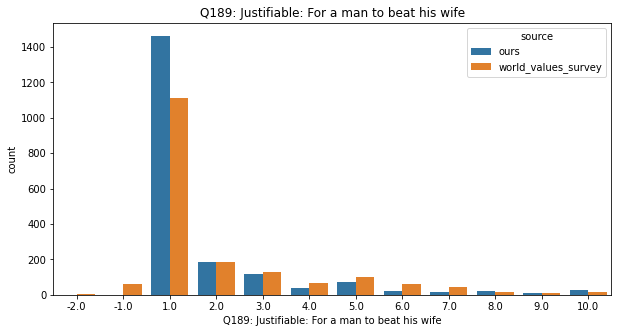

stat=161.459, p=0.000
Probably different distributions


6.713489314401543e-29

In [31]:

col = 'Q189: Justifiable: For a man to beat his wife'
plot_cats(df, col)
chi2test(df, col)

## Лояльнее к гомосексуализму

* среди молодёжи
* среди женщин и мужчин

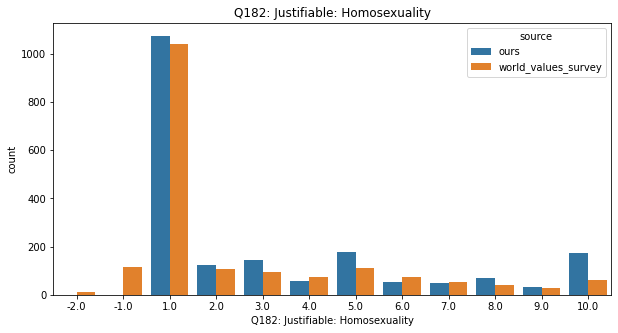

stat=215.098, p=0.000
Probably different distributions


5.416685051369182e-40

In [32]:
col = 'Q182: Justifiable: Homosexuality'
plot_cats(df, col)
chi2test(df, col)

## Чуть лояльнее относятся к проституткам

* среди всех возрастов
* среди женшин и мужчин

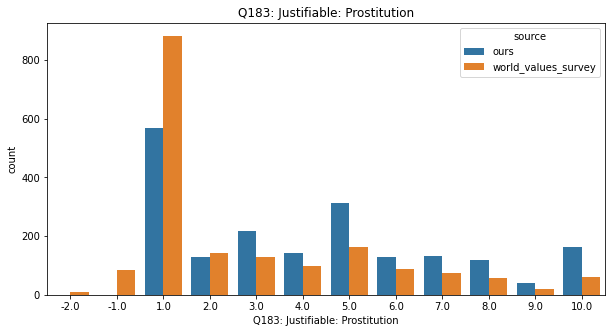

stat=334.960, p=0.000
Probably different distributions


3.673730595180772e-65

In [33]:
col = 'Q183: Justifiable: Prostitution'
plot_cats(df, col)
chi2test(df, col)

## В интернете спокойнее относятся к абортам

* среди всех возрастных групп
* среди женщин и мужчин

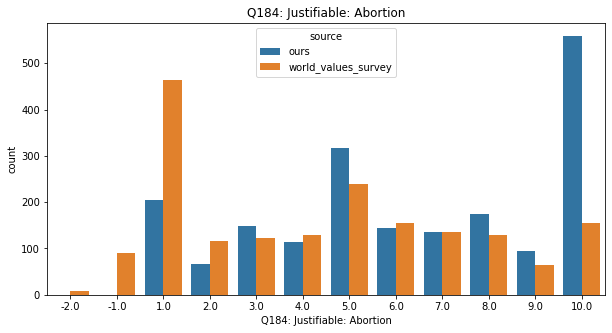

stat=462.542, p=0.000
Probably different distributions


3.078856499385238e-92

In [34]:

col = 'Q184: Justifiable: Abortion'
plot_cats(df, col)
chi2test(df, col)

## В интернете не хотят бить детей 

* среди всех групп населения, кроме молодёжи
* среди женщин и мужчин

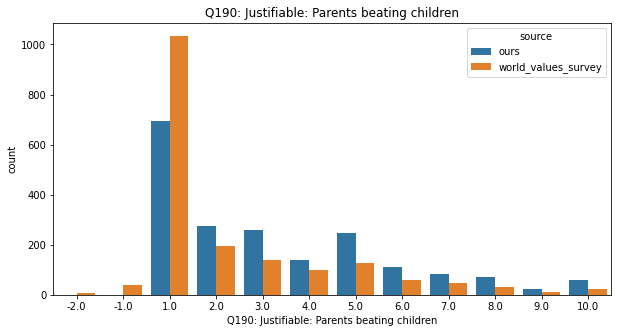

stat=263.233, p=0.000
Probably different distributions


4.707667957055548e-50

In [35]:

col = 'Q190: Justifiable: Parents beating children'
plot_cats(df, col)
chi2test(df, col)

## В Интернете люди более сексуально раскрепощённые (PREFERENCE FALSIFICATION)

* среди всех возрастных групп
* среди женщин и мужчин

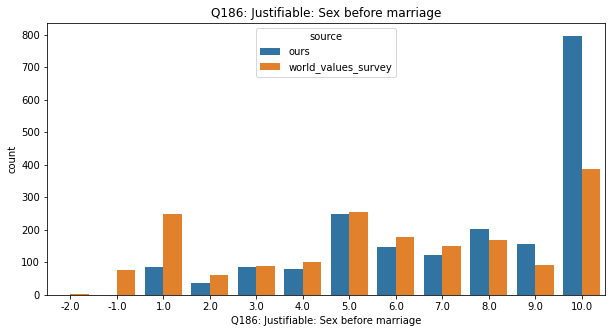

stat=327.467, p=0.000
Probably different distributions


1.407023541706457e-63

In [36]:
col = 'Q186: Justifiable: Sex before marriage'
plot_cats(df, col)
chi2test(df, col)

## Лояльнее к суициду

* среди всех возрастынх групп
* среди женщин и мужчин

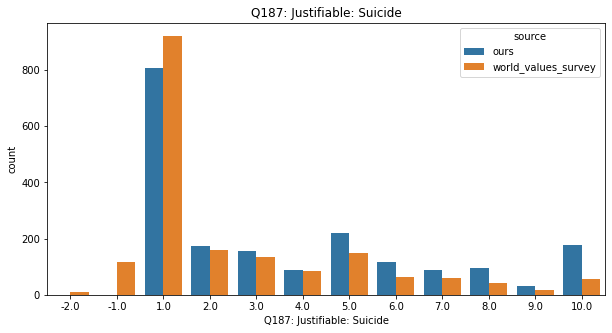

stat=258.015, p=0.000
Probably different distributions


5.848554799974308e-49

In [37]:

col = 'Q187: Justifiable: Suicide'
plot_cats(df, col)
chi2test(df, col)

## Более лояльны к эвтаназии

* среди всех возрастных групп
* среди женщин и мужчин

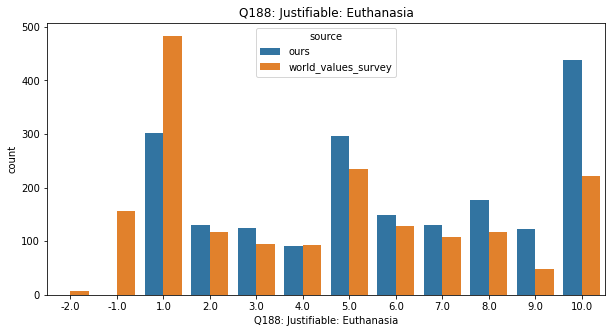

stat=330.398, p=0.000
Probably different distributions


3.381678145952058e-64

In [38]:
col = 'Q188: Justifiable: Euthanasia'
plot_cats(df, col)
chi2test(df, col)

## Более сексуально раскрепощённые

* среди всех возрастных групп
* среди женщин и мужчин

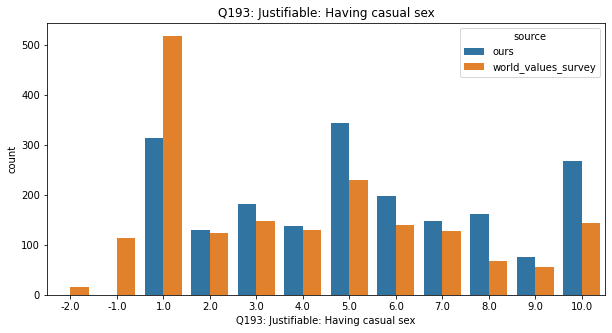

stat=290.151, p=0.000
Probably different distributions


1.0384816109292091e-55

In [39]:
col = 'Q193: Justifiable: Having casual sex'
plot_cats(df, col)
chi2test(df, col)

# Paper figures

In [40]:
question_cols = ['source', 'Q18: Neighbors: Drug addicts',
       'Q19: Neighbors: People of a different race',
       'Q22: Neighbors: Homosexuals',
       'Q21: Neighbors: Immigrants/foreign workers',
       'Q23: Neighbors: People of a different religion',
       'Q29: Men make better political leaders than women do',
       'Q36: Homosexual couples are as good parents as other couples',
       'Q212: Political action: Joining unofficial strikes',
       'Q71: Confidence: The Government', 'Q69: Confidence: The Police',
       'Q80: Confidence: The Women´s Movement',
       'Q227: How often in country´s elections: Voters are bribed',
       'Q130: Immigration policy preference',
       #'Q223: Which party would you vote for if there were a national election tomorrow',
       'Q189: Justifiable: For a man to beat his wife',
       'Q182: Justifiable: Homosexuality', 'Q183: Justifiable: Prostitution',
       'Q184: Justifiable: Abortion',
       'Q190: Justifiable: Parents beating children',
       'Q186: Justifiable: Sex before marriage', 'Q187: Justifiable: Suicide',
       'Q188: Justifiable: Euthanasia', 'Q193: Justifiable: Having casual sex'
]

In [41]:
# import plotly.express as px

# def assign_color(x):
#     if x == 'ours':
#         return 'blue'
#     else:
#         return 'green'

# color = [assign_color(c) for c in df.source.values]
# fig = px.parallel_categories(df, dimensions=question_cols[:5], color=color, color_continuous_scale=px.colors.sequential.Inferno)
# fig.show()

In [42]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return abs(u1 - u2) / s

col = question_cols[1]

effect_sizes = {}

for col in question_cols[1:]:
    ours = df[df.source=='ours'][col].dropna()
    wvs = df[df.source=='world_values_survey'][col].dropna()
    effect_sizes[col] = round(cohend(ours, wvs), 4)
effect_sizes

{'Q18: Neighbors: Drug addicts': 0.0182,
 'Q19: Neighbors: People of a different race': 0.3233,
 'Q22: Neighbors: Homosexuals': 0.7873,
 'Q21: Neighbors: Immigrants/foreign workers': 0.3077,
 'Q23: Neighbors: People of a different religion': 0.1572,
 'Q29: Men make better political leaders than women do': 0.1556,
 'Q36: Homosexual couples are as good parents as other couples': 0.0396,
 'Q212: Political action: Joining unofficial strikes': 0.3939,
 'Q71: Confidence: The Government': 0.0345,
 'Q69: Confidence: The Police': 0.0077,
 'Q80: Confidence: The Women´s Movement': 0.2335,
 'Q227: How often in country´s elections: Voters are bribed': 0.2608,
 'Q130: Immigration policy preference': 0.2592,
 'Q189: Justifiable: For a man to beat his wife': 0.1546,
 'Q182: Justifiable: Homosexuality': 0.2781,
 'Q183: Justifiable: Prostitution': 0.53,
 'Q184: Justifiable: Abortion': 0.6698,
 'Q190: Justifiable: Parents beating children': 0.4428,
 'Q186: Justifiable: Sex before marriage': 0.5731,
 'Q18

In [43]:
#        |   age |  
# ---------------------------
# male   |   ours/notours |
# female |

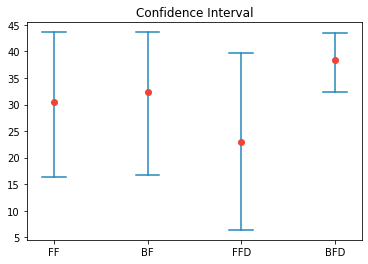

In [44]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt
from scipy.stats import bootstrap

def plot_confidence_interval(x, values,  label=None, color='#2187bb', horizontal_line_width=0.25, ax = None):
    mean = np.mean(values)
    confidence_interval = bootstrap((values,), np.mean, confidence_level=0.95).confidence_interval
    
    top = confidence_interval.low
    bottom = confidence_interval.high
    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    ax = ax or plt.gca()
    
    ax.plot([x, x], [top, bottom], color=color, label=label)
    ax.plot([left, right], [top, top], color=color)
    ax.plot([left, right], [bottom, bottom], color=color)
    ax.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


plt.xticks([1, 2, 3, 4], ['FF', 'BF', 'FFD', 'BFD'])
plt.title('Confidence Interval')
plot_confidence_interval(1, [10, 11, 42, 45, 44])
plot_confidence_interval(2, [10, 21, 42, 45, 44])
plot_confidence_interval(3, [20, 2, 4, 45, 44])
plot_confidence_interval(4, [30, 31, 42, 45, 44])
plt.show()

In [45]:
col = question_cols[1]
ours = df[df.source=='ours'][col].dropna()
wvs = df[df.source=='world_values_survey'][col].dropna()
col

'Q18: Neighbors: Drug addicts'

In [46]:
df.source_sex

0       female
2       female
7       female
9       female
10      female
         ...  
4459      male
4460      male
4461      male
4462    female
4463      male
Name: source_sex, Length: 3767, dtype: object

In [47]:
df.source_age.unique()

array(['50+', '30-49', '29'], dtype=object)

In [49]:
def assign_color(source):
    if source == 'ours':
        return 'red'
    else:
        return 'blue'

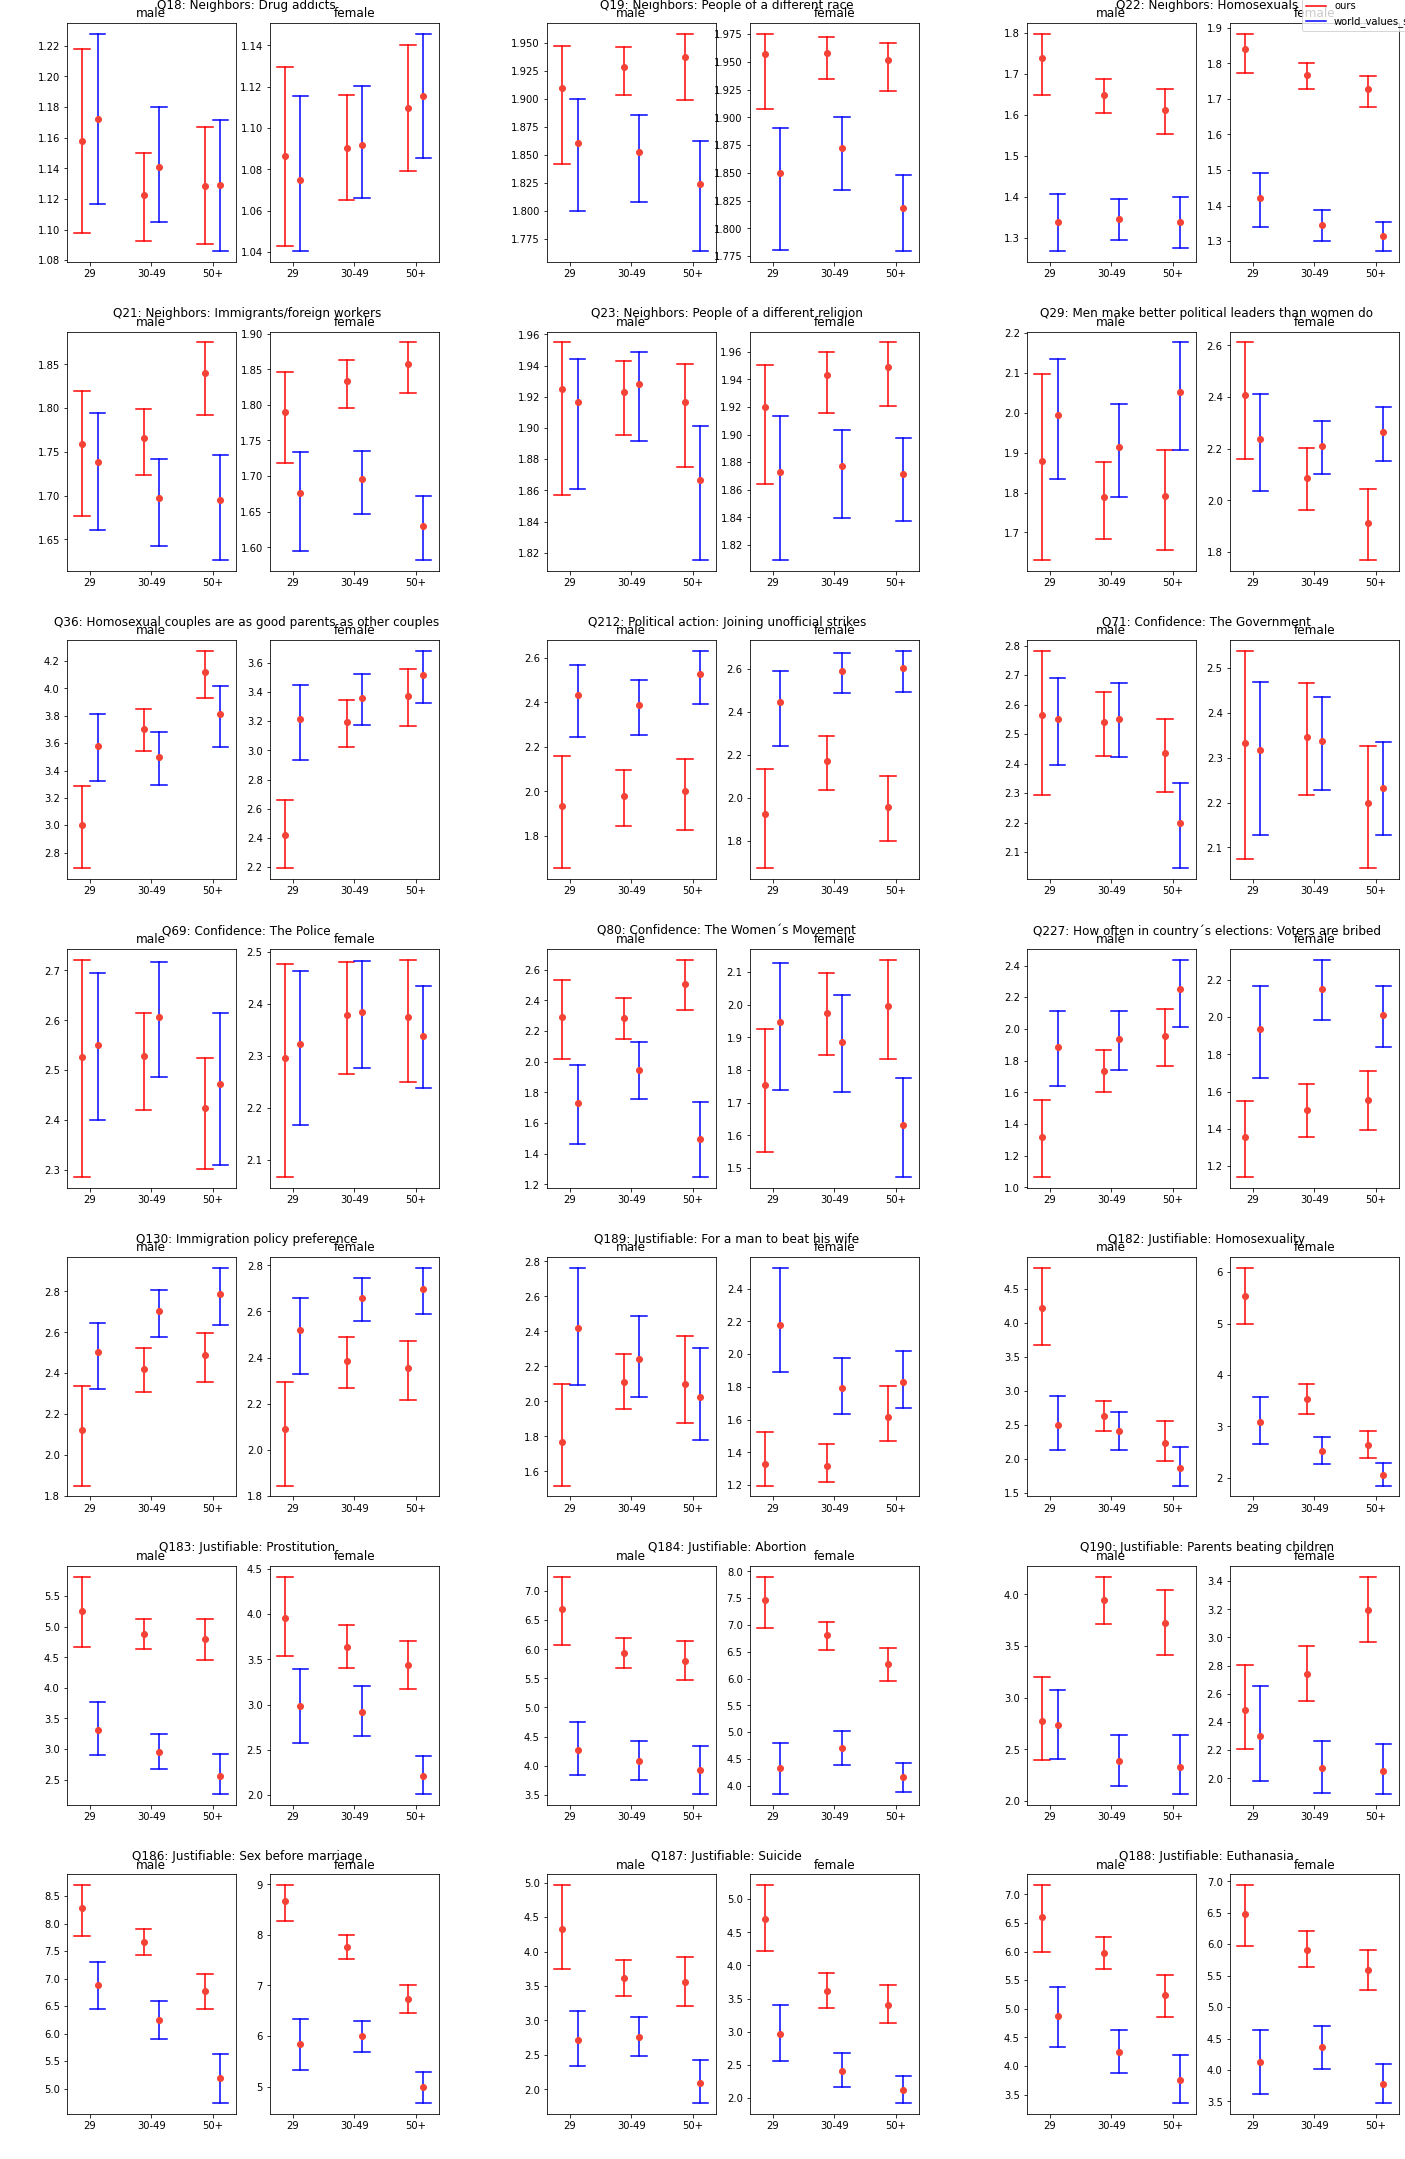

In [51]:
total_cols = question_cols[1:]

fig = plt.figure(figsize=(20, 30))
fig.suptitle(' ')

ncols = 3
subfigs = fig.subfigures(nrows=round(len(total_cols)/ncols), ncols=ncols)
for row, row_subfigs in enumerate(subfigs):
    for col, subfig in enumerate(row_subfigs):
        if row*len(row_subfigs)+col >= len(total_cols):
            break
        col = total_cols[row*len(row_subfigs)+col]
        subfig.suptitle(f'{col}')
        
        if row == 0:
            subfig.subplots_adjust(top=0.9)
        else:
            subfig.subplots_adjust(top=None)
            
        axs = subfig.subplots(nrows=1, ncols=2)
        counter = 0
        for i, sex in enumerate(['male', 'female']):
            ax = axs[counter]
            counter += 1
            ticks = []
            for j, age in enumerate(['29', '30-49', '50+']):
                for k, source in enumerate(['ours', 'world_values_survey']):
                    vals = df[(df.source==source)&(df.source_sex==sex)&(df.source_age==age)][col].dropna()
                    #vals = vals[vals!=-1]
                    plot_confidence_interval(j+k*0.25, vals, color=assign_color(source), label=source, ax=ax)
                ticks.append((j + j+k*0.25)/2)
            ax.set_xticks(ticks, ['29', '30-49', '50+'])
            ax.set_title(f'{sex}')
            # ax.set_yticks([])
            ax.plot()
    if row == 0:
        handles, labels = ax.get_legend_handles_labels()
        handles, labels = handles[:2], labels[:2]
        subfig.legend(handles, labels, loc='upper right')


#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
#plt.margins(y=0.5)

plt.savefig('atlas.png')
plt.show()

### Findings
* Differ significantly:
  * Neighbors of different race
  * Neighbors homosexuals
  * Neighbors imigrants
  * Elections bribed
  * Abortion
  * Sex before marriage
  * Justifiable suicide
  * Suicide
  * Euthanasia
  
* Questions:
  * Homosexual neighbors vs justifiable homosexuality vs homosexual couples?
  * Casual sex vs sex before marriage?
  * People of a different race vs immigrant workers vs immigration policy?
  * Suicide vs euthanasia?
  * Voters are bribed vs government vs police?
  * Man beating wife vs parents beating children?
  
  
* Findings:
  * Significant differences on all sex-related questions
  * No difference on questions like drug addicts

# Findings and proofs

## Homosexual neighbors vs justifiable homosexuality vs homosexual couples?

* In all 3 related questions, people on the internet are consistently less homophobic.
* You would expect older people to be more homophobic, it holds.
* You would expect women to be less homophobic, it holds.
* The biggest difference manifsts in the youngest age group. 

**Young people on the internet are significantly less homophobic, even though on the street survey their answers are not significantly different from other age groups** 

In [52]:
def conf_interval_plot(col):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(col)
    counter = 0
    for i, sex in enumerate(['male', 'female']):
        ax = axs[counter]
        counter += 1
        ticks = []
        for j, age in enumerate(['29', '30-49', '50+']):
            for k, source in enumerate(['ours', 'world_values_survey']):
                vals = df[(df.source==source)&(df.source_sex==sex)&(df.source_age==age)][col].dropna()
                plot_confidence_interval(j+k*0.25, vals, color=assign_color(source), label=source, ax=ax)
            ticks.append((j + j+k*0.25)/2)
        ax.set_xticks(ticks, ['29', '30-49', '50+'])
        ax.set_title(f'{sex}')
        # ax.set_yticks([])
        ax.plot()

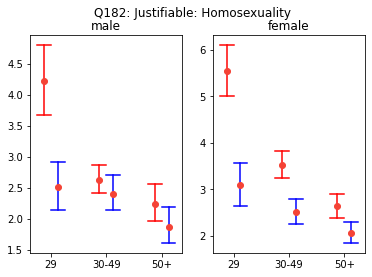

In [53]:
col = 'Q182: Justifiable: Homosexuality'
conf_interval_plot(col)

1 - dont want neighbor, 10 - want neighbor


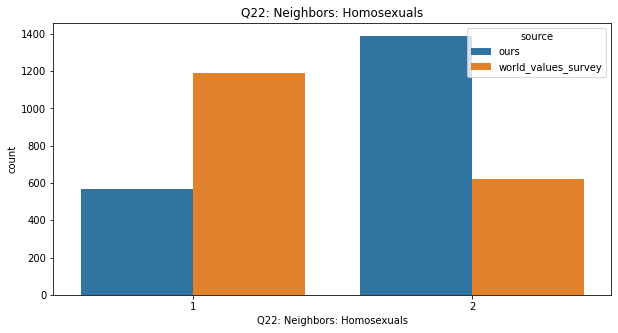

1 - disagree, 10 - agree


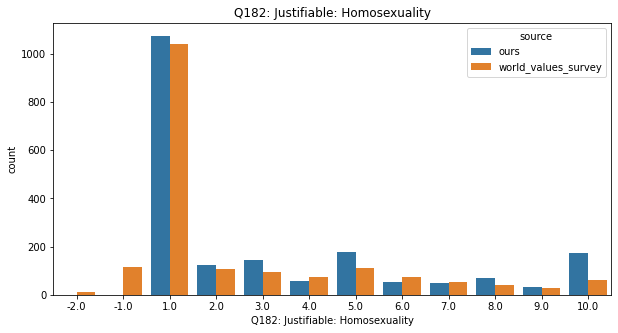

1 - agree, 5 - disagree


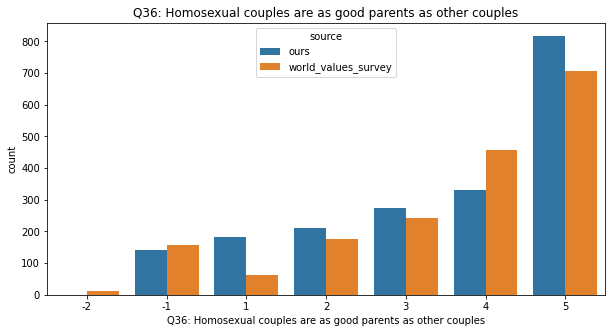

In [54]:
print('1 - dont want neighbor, 10 - want neighbor')
plot_cats(df, 'Q22: Neighbors: Homosexuals')

print('1 - disagree, 10 - agree')
plot_cats(df, 'Q182: Justifiable: Homosexuality')

print('1 - agree, 5 - disagree')
plot_cats(df, 'Q36: Homosexual couples are as good parents as other couples')


In [55]:
chi2test(df, 'Q22: Neighbors: Homosexuals'), chi2test(df, 'Q182: Justifiable: Homosexuality'),  chi2test(df, 'Q36: Homosexual couples are as good parents as other couples')

stat=505.028, p=0.000
Probably different distributions
stat=215.098, p=0.000
Probably different distributions
stat=100.766, p=0.000
Probably different distributions


(7.656147047197572e-112, 5.416685051369182e-40, 1.7363938815179288e-19)

1 - disagree, 10 - agree


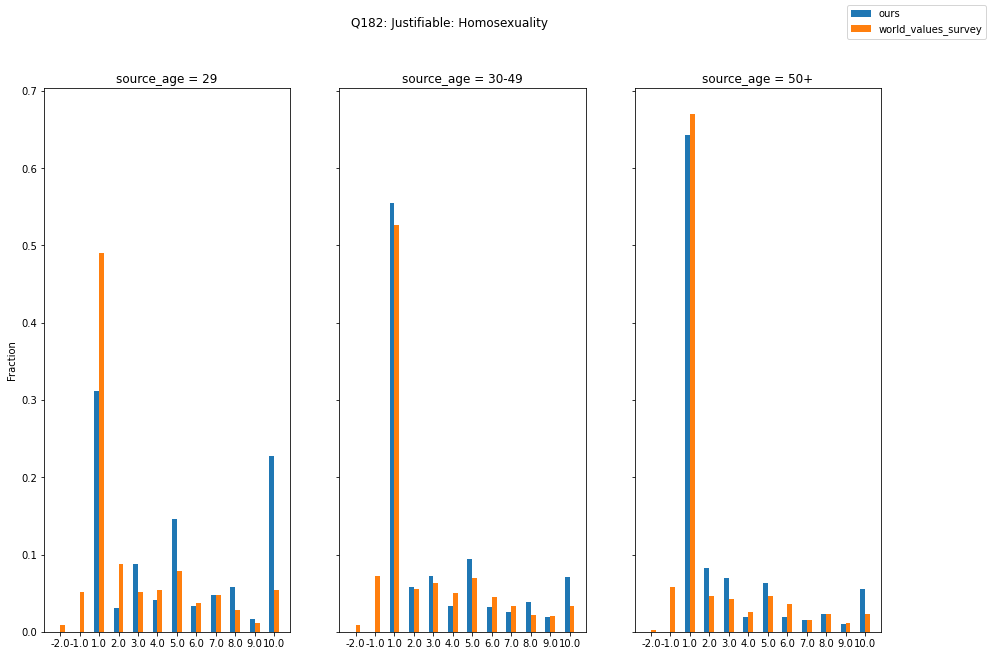

In [56]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df, 'Q182: Justifiable: Homosexuality', 'source_age')

1 - disagree, 10 - agree


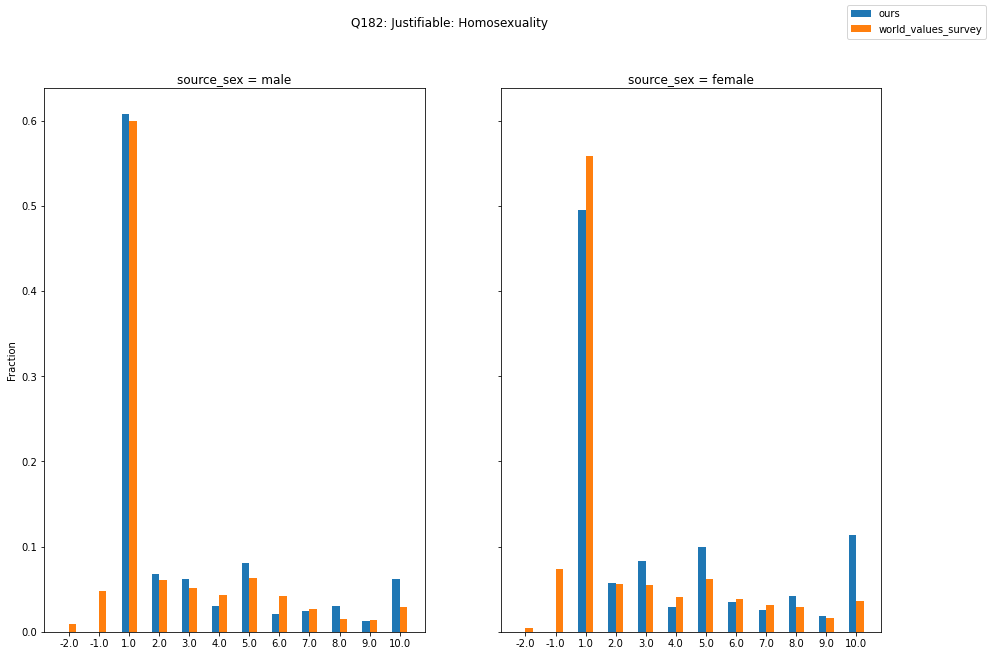

In [57]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df, 'Q182: Justifiable: Homosexuality', 'source_sex')

1 - agree, 5 - disagree


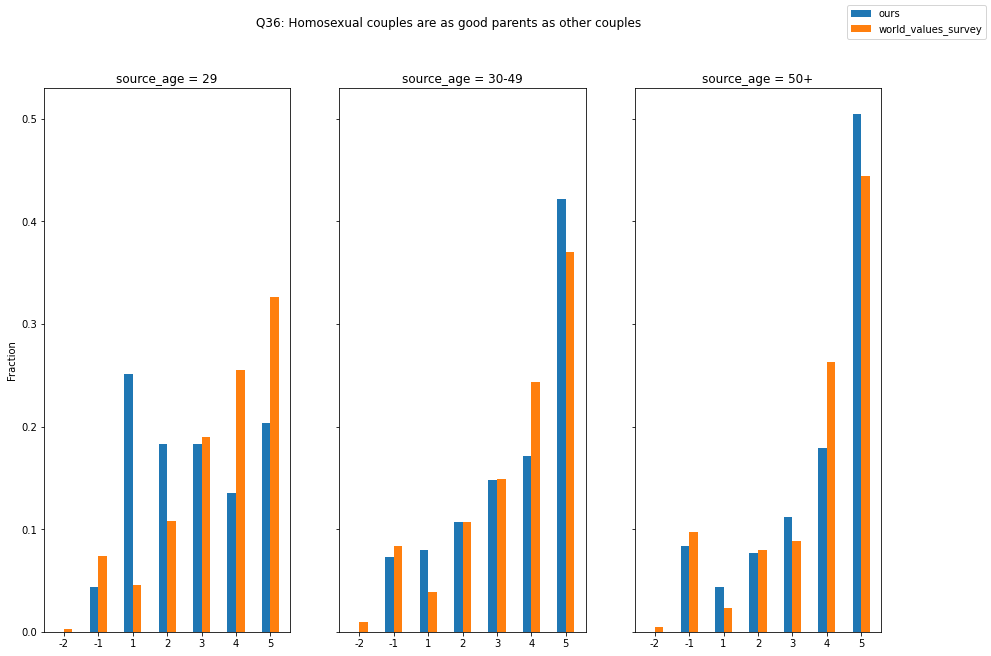

In [58]:
print('1 - agree, 5 - disagree')
plot_cats_by_category_normalized(df,  'Q36: Homosexual couples are as good parents as other couples', 'source_age')

## Casual sex vs sex before marriage?

* In both questions we find that people on the internet are consistently more open-minded
* An most extreme difference is evident on the "having casual sex" question. In WVS survey a lot of respondents are on the "completely disagree" extreme. In our survey, the responses are more evenly distributed, with the majority not being against casual sex.
* The biggest difference is observed among females. 
* Old people in the survey internet appear to be more pro-sex before marriage than young people in wvs survey.

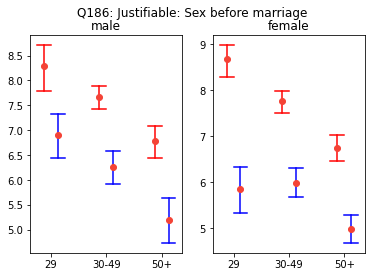

In [60]:
col = 'Q186: Justifiable: Sex before marriage'
conf_interval_plot(col)

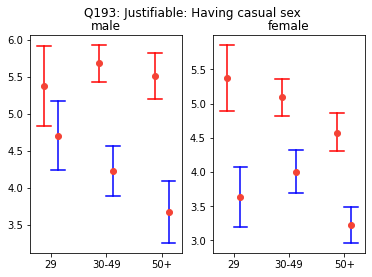

In [61]:
col = 'Q193: Justifiable: Having casual sex'
conf_interval_plot(col)

1 - disagree, 10 - agree


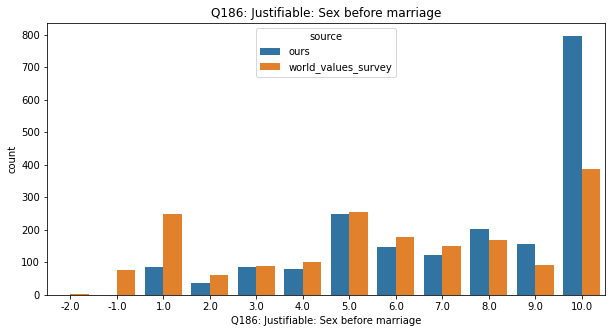

1 - disagree, 10 - agree


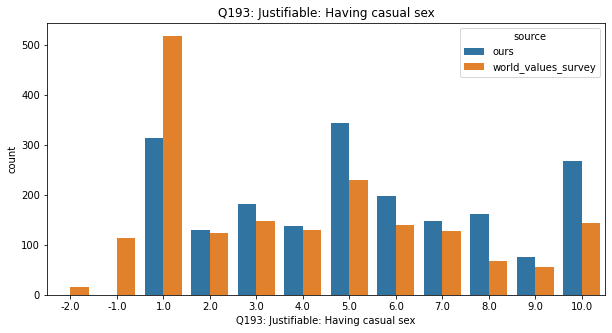

In [62]:
print('1 - disagree, 10 - agree')
plot_cats(df, 'Q186: Justifiable: Sex before marriage')

print('1 - disagree, 10 - agree')
plot_cats(df, 'Q193: Justifiable: Having casual sex')

1 - disagree, 10 - agree


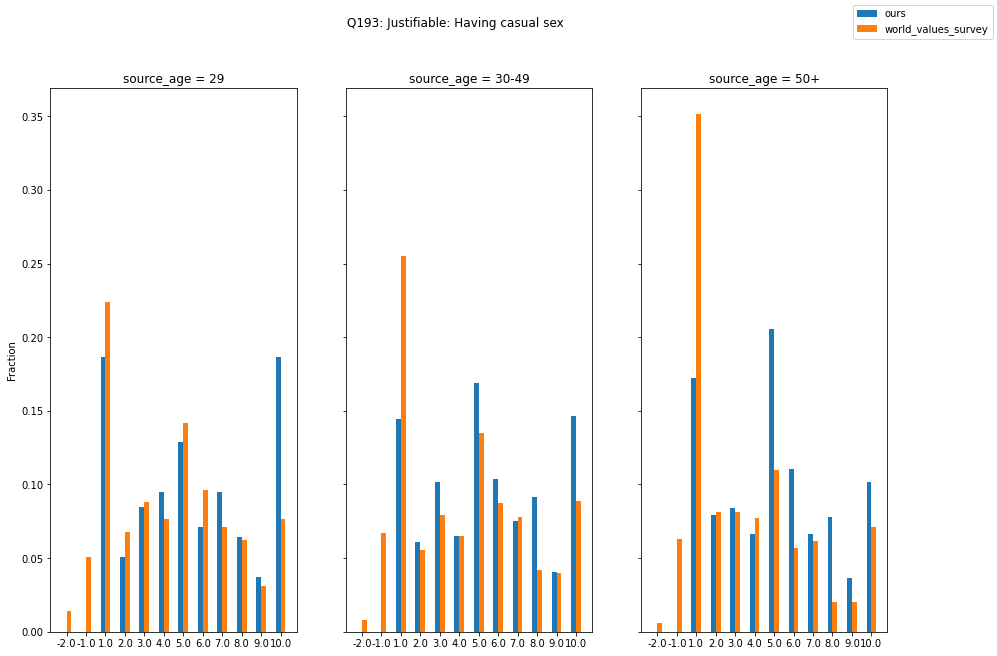

In [63]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df,  'Q193: Justifiable: Having casual sex', 'source_age')

1 - disagree, 10 - agree


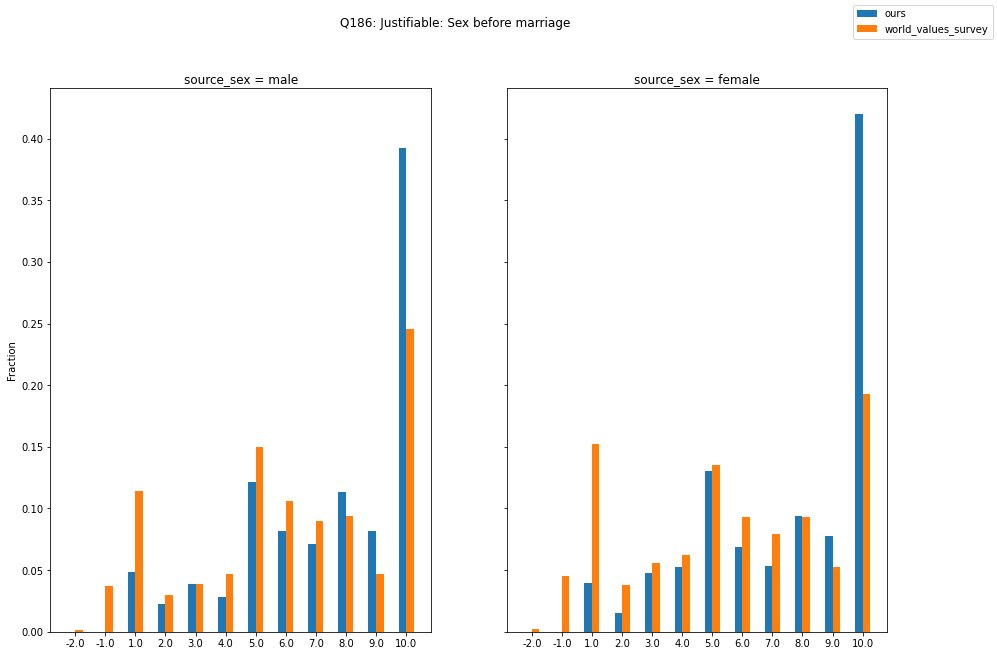

In [64]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df,  'Q186: Justifiable: Sex before marriage', 'source_sex')

## Immigrants vs immigraton policty vs different race?

Nothing super interesting

* People on the internet tend to be more often in favor of restrictions, but less often in favor of complete ban of immigrants
* People on the internet more often answer "I dont know"
* Older people not significantly more for immigration bans - no idea
* No real difference between sexes

 

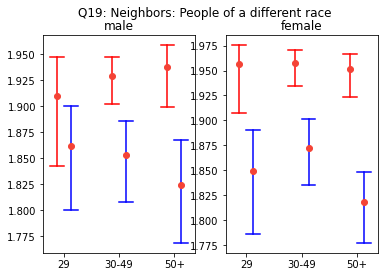

In [65]:
#'Q21: Neighbors: Immigrants/foreign workers',
#'Q130: Immigration policy preference',
#'Q19: Neighbors: People of a different race',

col = 'Q19: Neighbors: People of a different race'

conf_interval_plot(col)

1 - dont want neighbor, 2 - want neighbor


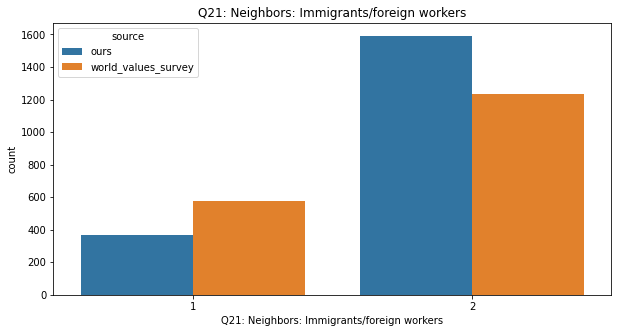

1 - dont want neighbor, 2 - want neighbor


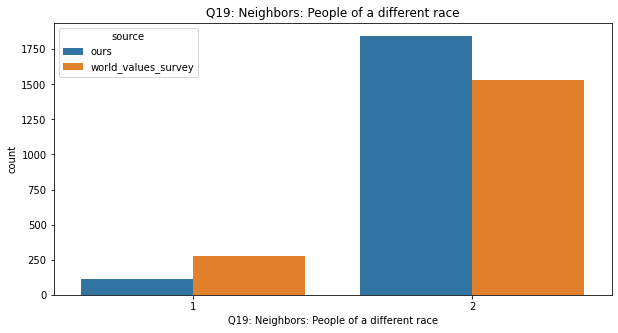


'Мы должны пускать всех желающих': 1,
'Пускать всех желающих до тех пор, пока есть рабочие места': 2,
'Установить жесткие ограничения на количество иностранцев, которые могут сюда приехать': 3,
'Запретить приезжать сюда из других стран': 4,
'Затрудняюсь ответить': -1,



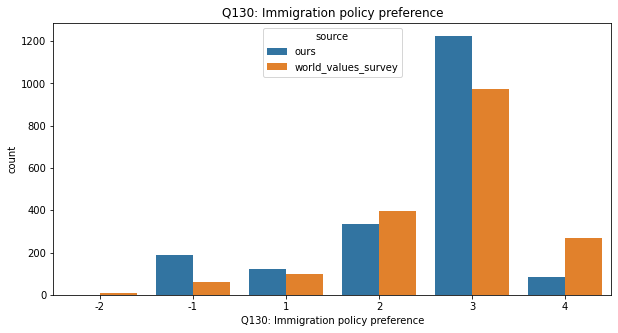

In [66]:
print('1 - dont want neighbor, 2 - want neighbor')
plot_cats(df, 'Q21: Neighbors: Immigrants/foreign workers')

print('1 - dont want neighbor, 2 - want neighbor')
plot_cats(df, 'Q19: Neighbors: People of a different race')

print("""
'Мы должны пускать всех желающих': 1,
'Пускать всех желающих до тех пор, пока есть рабочие места': 2,
'Установить жесткие ограничения на количество иностранцев, которые могут сюда приехать': 3,
'Запретить приезжать сюда из других стран': 4,
'Затрудняюсь ответить': -1,
""")
plot_cats(df, 'Q130: Immigration policy preference')


1 - disagree, 10 - agree


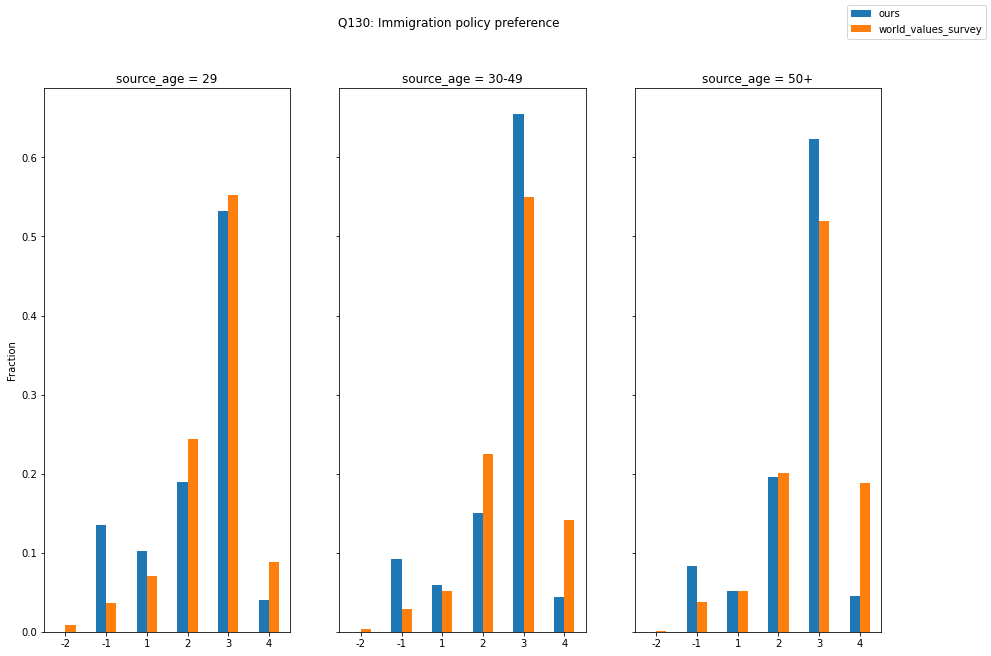

In [67]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df, 'Q130: Immigration policy preference', 'source_age')

## Man beating wife vs parents beating children?
Not super interesting
* On the internet people find beating children significantly more justifiable, then on the street
* At the same time they find a man beating his wife less justifiable

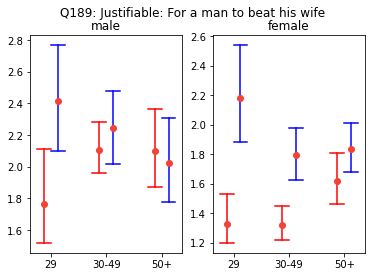

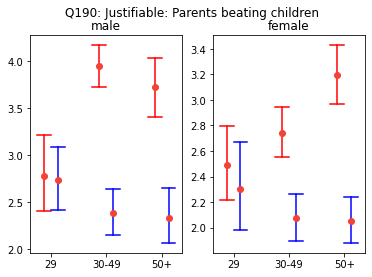

In [68]:
col = 'Q189: Justifiable: For a man to beat his wife'
conf_interval_plot(col)

conf_interval_plot('Q190: Justifiable: Parents beating children')

1 - disagree, 10 - agree


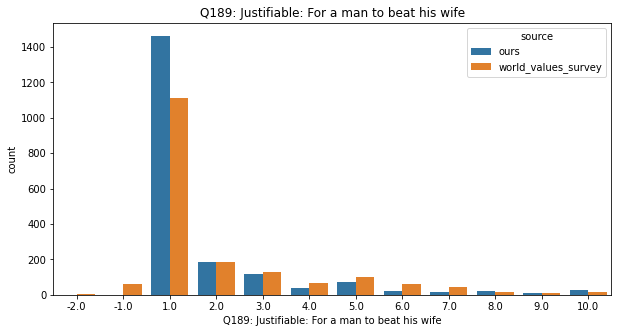

1 - disagree, 10 - agree


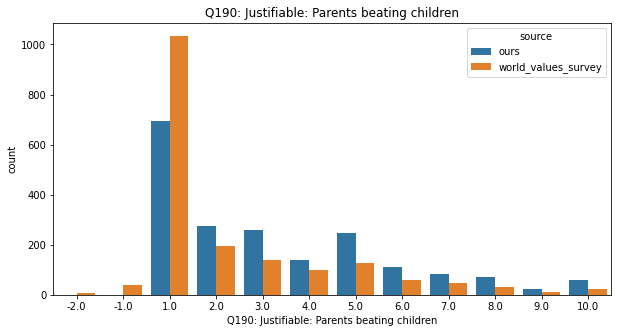

In [69]:
print('1 - disagree, 10 - agree')
plot_cats(df, 'Q189: Justifiable: For a man to beat his wife')

print('1 - disagree, 10 - agree')
plot_cats(df, 'Q190: Justifiable: Parents beating children')

1 - disagree, 10 - agree


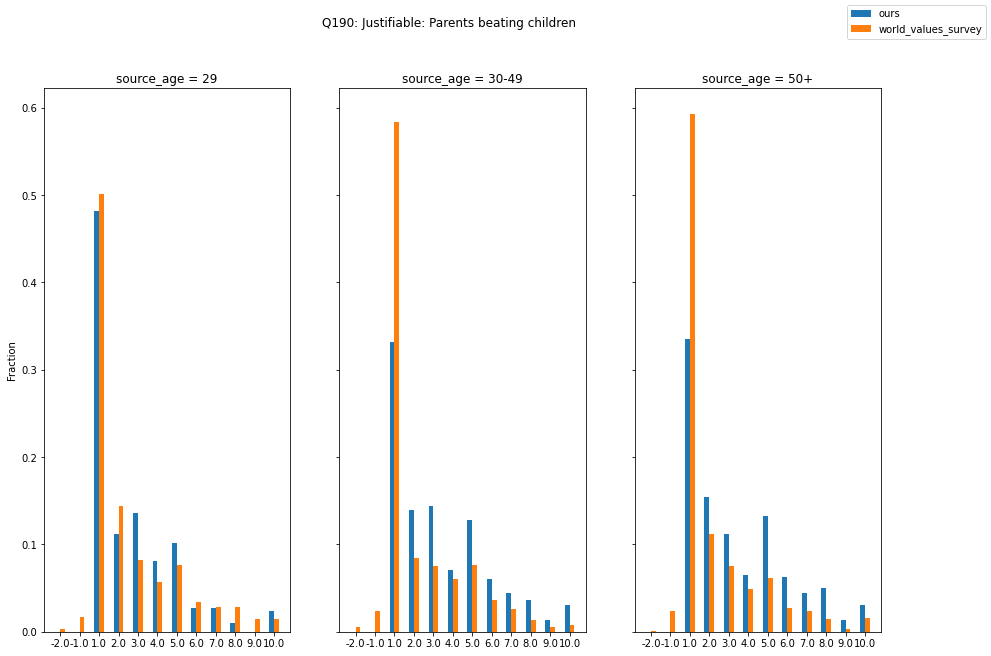

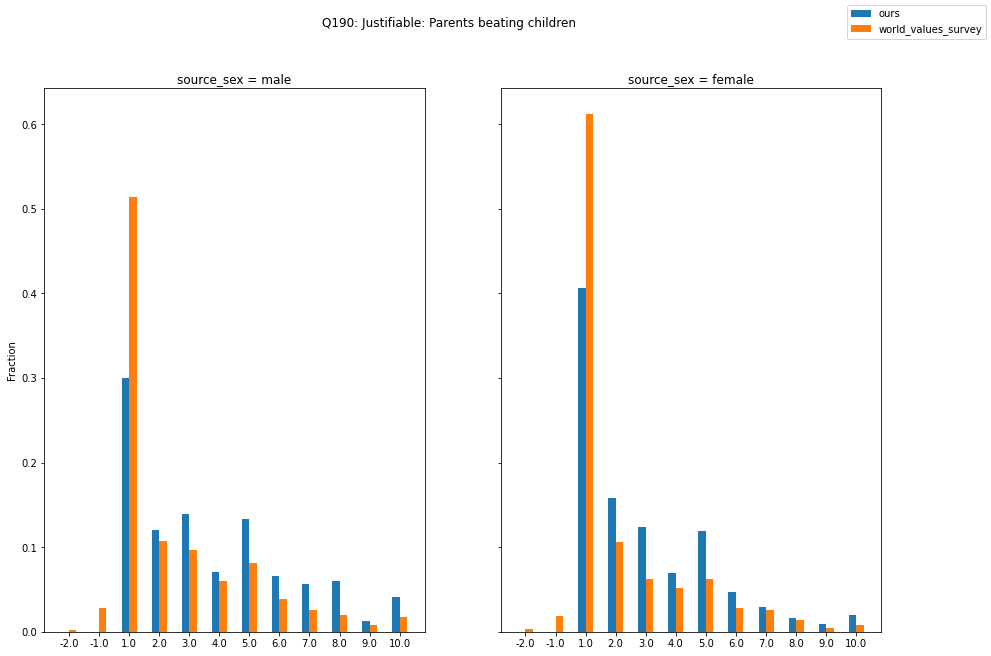

In [70]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df, 'Q190: Justifiable: Parents beating children', 'source_age')
plot_cats_by_category_normalized(df, 'Q190: Justifiable: Parents beating children', 'source_sex')

## Suicide vs euthanasia?

* People on the internet significantly more accepting of euthanasia and suicide
* Predictably, young people are more accepting than older people


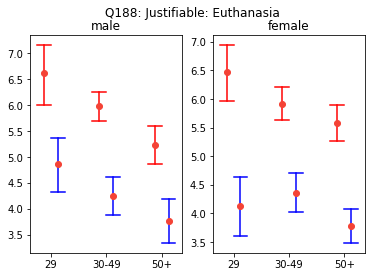

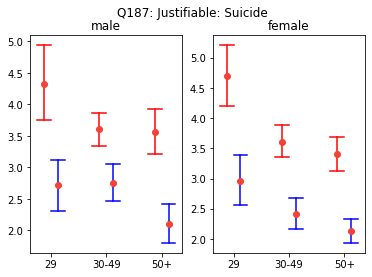

In [71]:
conf_interval_plot('Q188: Justifiable: Euthanasia')

conf_interval_plot('Q187: Justifiable: Suicide')

1 - disagree, 10 - agree


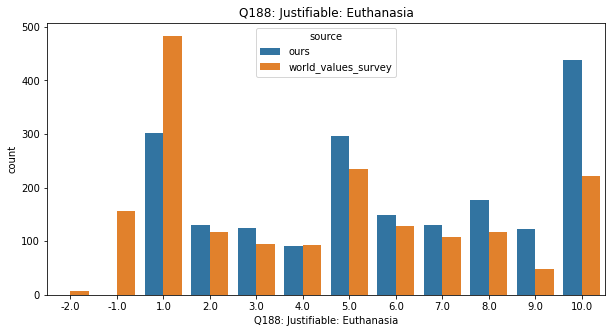

1 - disagree, 10 - agree


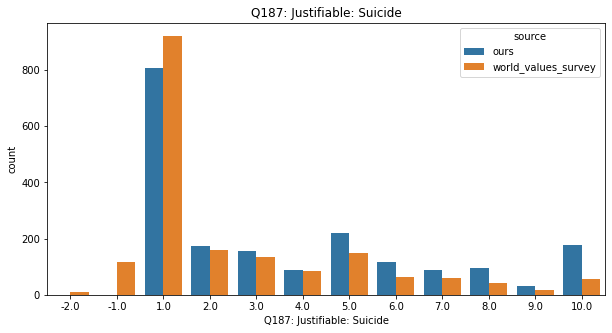

In [72]:
print('1 - disagree, 10 - agree')
plot_cats(df, 'Q188: Justifiable: Euthanasia')

print('1 - disagree, 10 - agree')
plot_cats(df, 'Q187: Justifiable: Suicide')

1 - disagree, 10 - agree


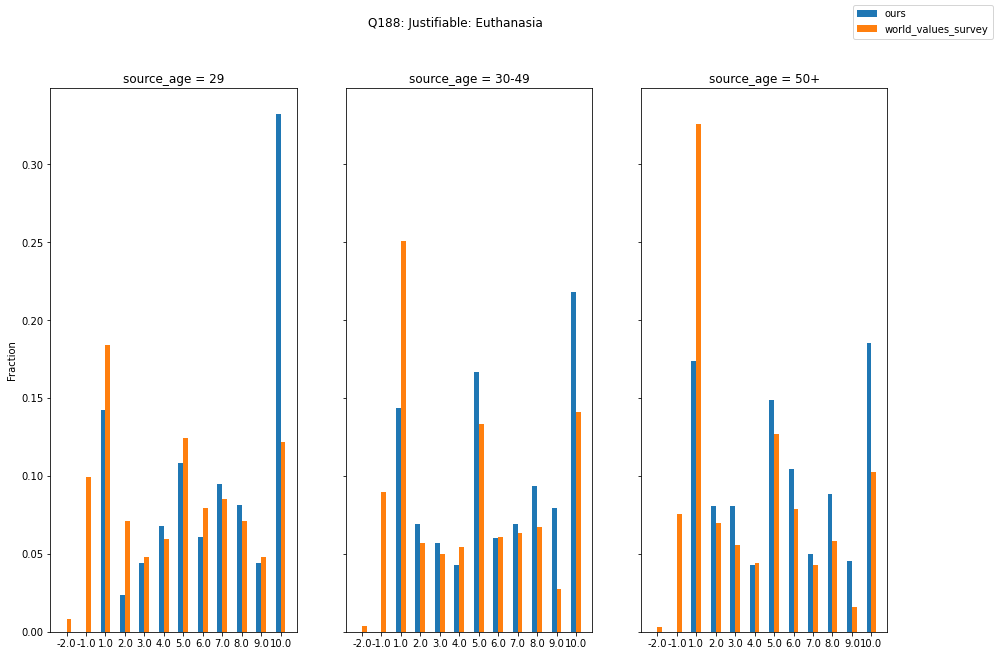

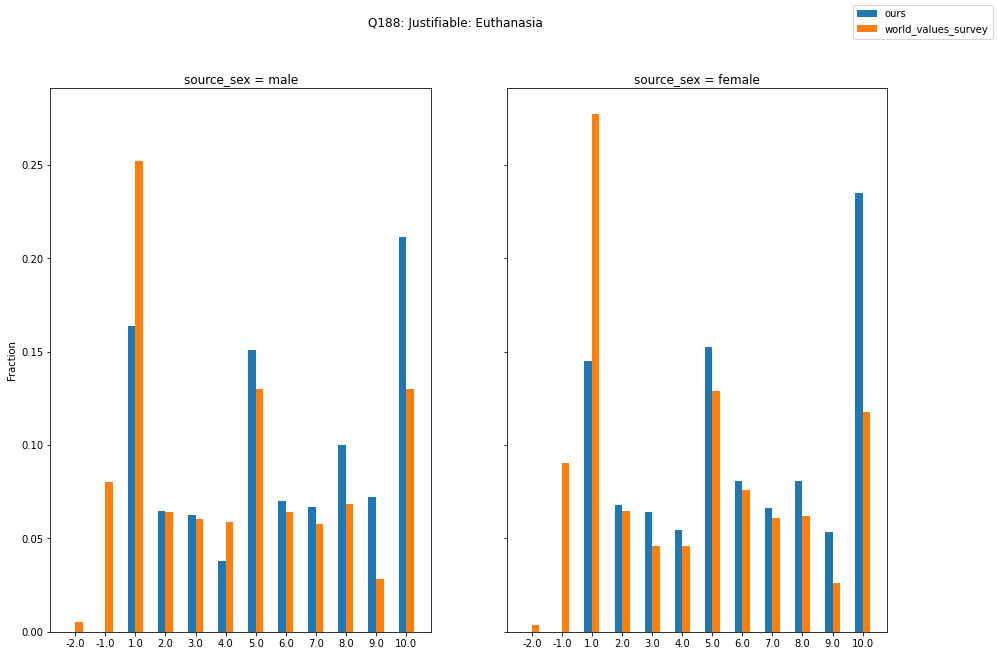

In [73]:
print('1 - disagree, 10 - agree')
plot_cats_by_category_normalized(df, 'Q188: Justifiable: Euthanasia', 'source_age')
plot_cats_by_category_normalized(df, 'Q188: Justifiable: Euthanasia', 'source_sex')

## Voters are bribed vs government vs police?

* People on the internet more easily admit joining strikes and suspect voters are bribed.
* No significant different in government confidence and trust in police. Why?
* Young people not more likely to join unofficial strikes: wtf?
* Young people display less trust in government, as expected. Much less on the internet than on the street

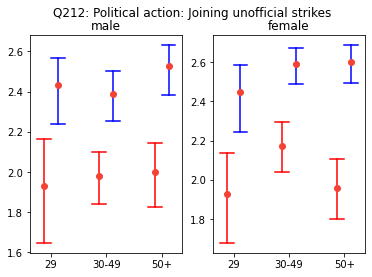

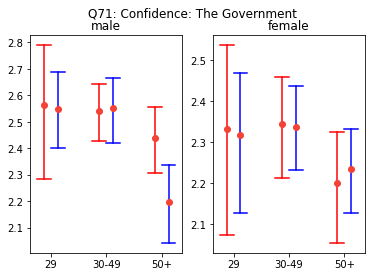

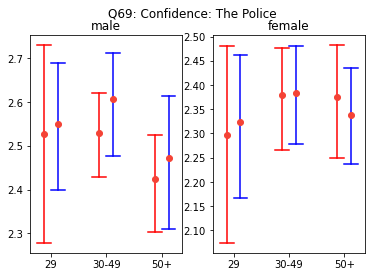

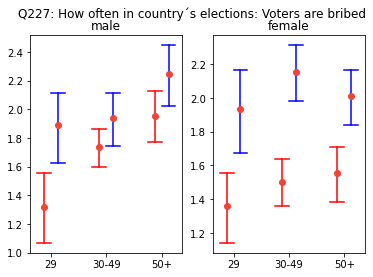

In [74]:
conf_interval_plot('Q212: Political action: Joining unofficial strikes')
conf_interval_plot('Q71: Confidence: The Government')
conf_interval_plot('Q69: Confidence: The Police')
conf_interval_plot('Q227: How often in country´s elections: Voters are bribed')


'Уже посещал': 1,
'Мог бы посетить': 2,
'Никогда бы не посетил': 3,
'Затрудняюсь ответить': -1,



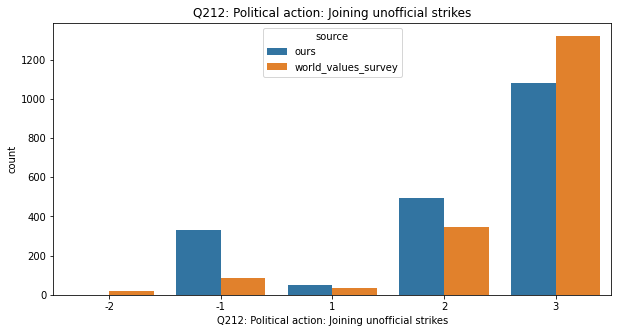


'Затрудняюсь ответить': -1,
'Полностью доверяю': 1,
'Скорее доверяю': 2,
'Скорее не доверяю': 3,
'Абсолютно не доверяю': 4



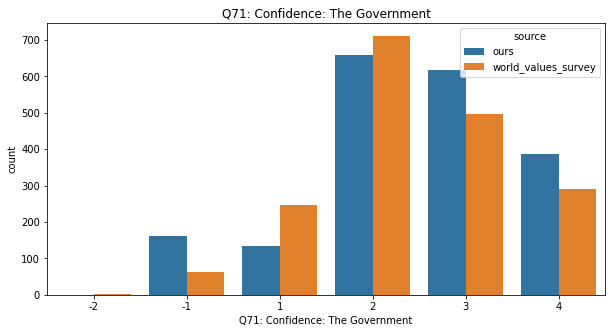


'Очень часто': 1,
'Скорее часто': 2,
'Не очень часто': 3,
'Совсем не часто': 4,
'Затрудняюсь ответить': -1,



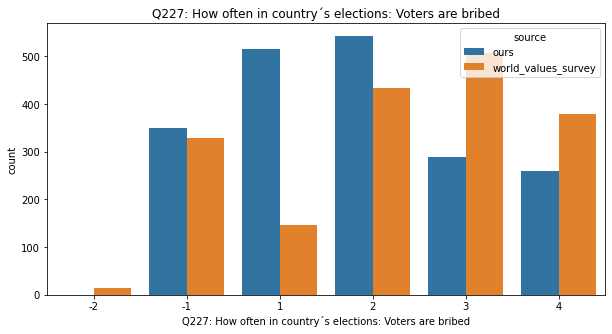

In [75]:
print("""
'Уже посещал': 1,
'Мог бы посетить': 2,
'Никогда бы не посетил': 3,
'Затрудняюсь ответить': -1,
""")
plot_cats(df, 'Q212: Political action: Joining unofficial strikes')

print("""
'Затрудняюсь ответить': -1,
'Полностью доверяю': 1,
'Скорее доверяю': 2,
'Скорее не доверяю': 3,
'Абсолютно не доверяю': 4
""")
plot_cats(df, 'Q71: Confidence: The Government')

print("""
'Очень часто': 1,
'Скорее часто': 2,
'Не очень часто': 3,
'Совсем не часто': 4,
'Затрудняюсь ответить': -1,
""")
plot_cats(df, 'Q227: How often in country´s elections: Voters are bribed')

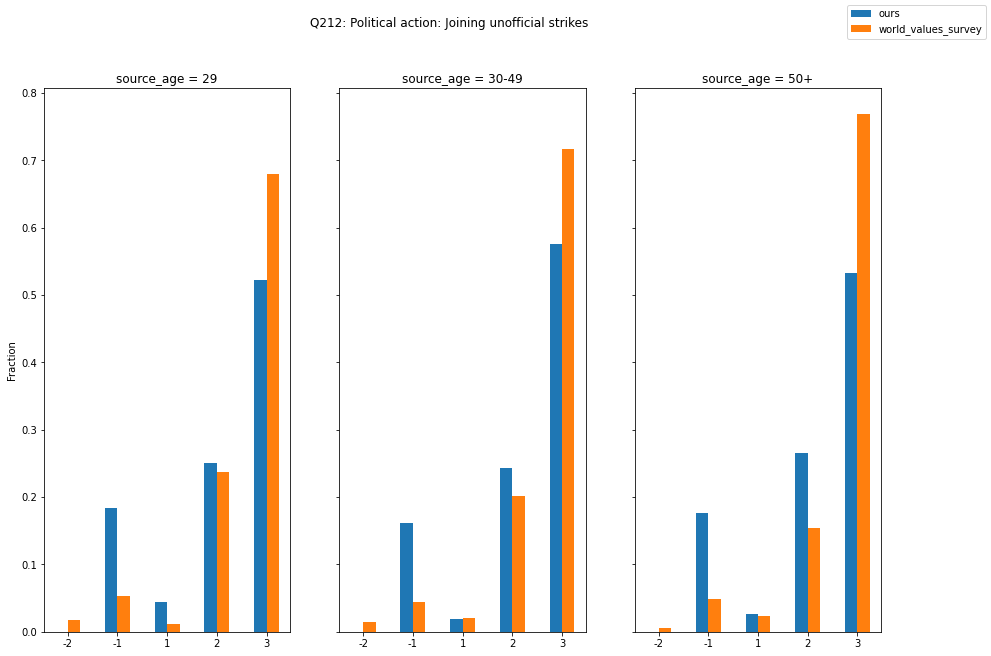

In [76]:
plot_cats_by_category_normalized(df, 'Q212: Political action: Joining unofficial strikes', 'source_age')

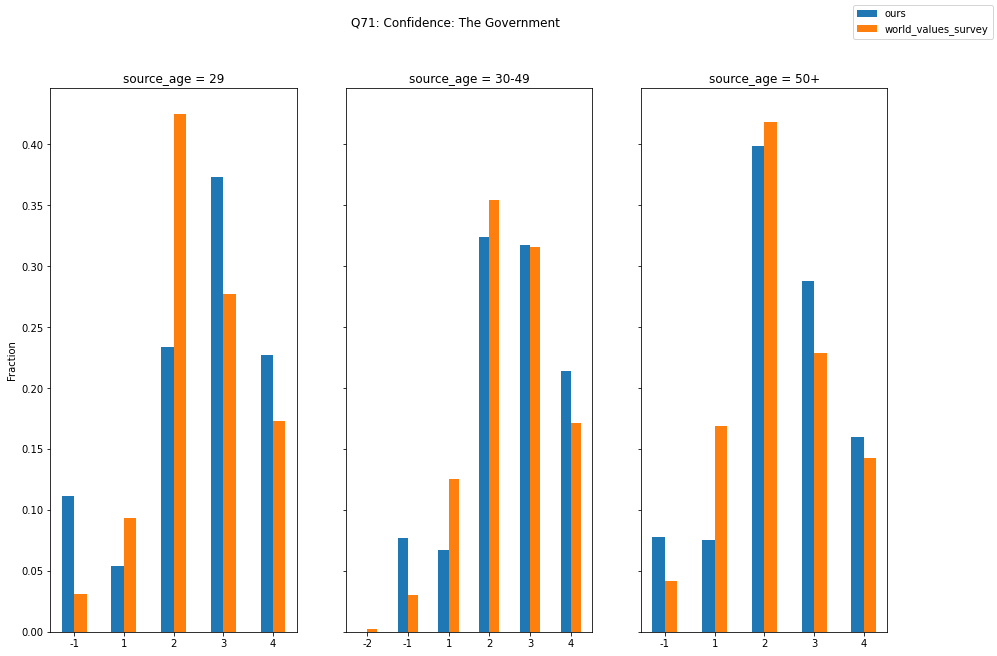

In [77]:
plot_cats_by_category_normalized(df, 'Q71: Confidence: The Government', 'source_age')